# Analyzing Uniform Quantization Function

## Standard nbitlineardynamic
From https://github.com/Vincent-La/lavis_clone/blob/main/lavis/layers/nbitlineardynamic.py

In [1]:
'''
nbitlinear.py from https://github.com/Vincent-La/lavis_clone/blob/main/lavis/layers/nbitlineardynamic.py
'''

from torch import nn, Tensor
import torch.nn.functional as F

def quant(x: Tensor, num_bits):
    min_val = x.min(dim=-1).values.unsqueeze(-1)
    max_val = x.max(dim=-1).values.unsqueeze(-1)
    
    alpha = max_val - min_val
    x = (x-min_val)/alpha
    
    scale = (2**num_bits - 1)
    result = (scale *x).round()
    result /= scale
    
    result = alpha * result + min_val
    
    return result
    

class NBitLinearDynamic(nn.Linear):
    def __init__(self,
                 *kargs,
                 weight_bits=8,
                 activation_bits=8,
                 **kwargs
    ):
        super().__init__(*kargs, **kwargs)
        self.weight_bits     = weight_bits
        self.activation_bits = activation_bits
        
    def forward(self, x: Tensor) -> Tensor:
        w = self.weight
        b = self.bias

        x_quant = x + (quant(x, self.activation_bits) - x).detach()
        w_quant = w + (quant(w, self.weight_bits) - w).detach()
        
        if b != None:
            b = b + (quant(b, self.weight_bits) - b).detach()
        
        y = F.linear(x_quant, w_quant, bias = b)
        
        return y
    
    def extra_repr(self) -> str:
        return super().extra_repr() + f' | w={self.weight_bits}, a={self.activation_bits}'

## Testing quantization of params


1-bit Quantization:
Min value: -2.6133224964141846
Max value: 3.4105026721954346
Unique values: 2

2-bit Quantization:
Min value: -2.6133224964141846
Max value: 3.4105026721954346
Unique values: 4

4-bit Quantization:
Min value: -2.6133224964141846
Max value: 3.4105026721954346
Unique values: 15

8-bit Quantization:
Min value: -2.6133224964141846
Max value: 3.4105026721954346
Unique values: 76


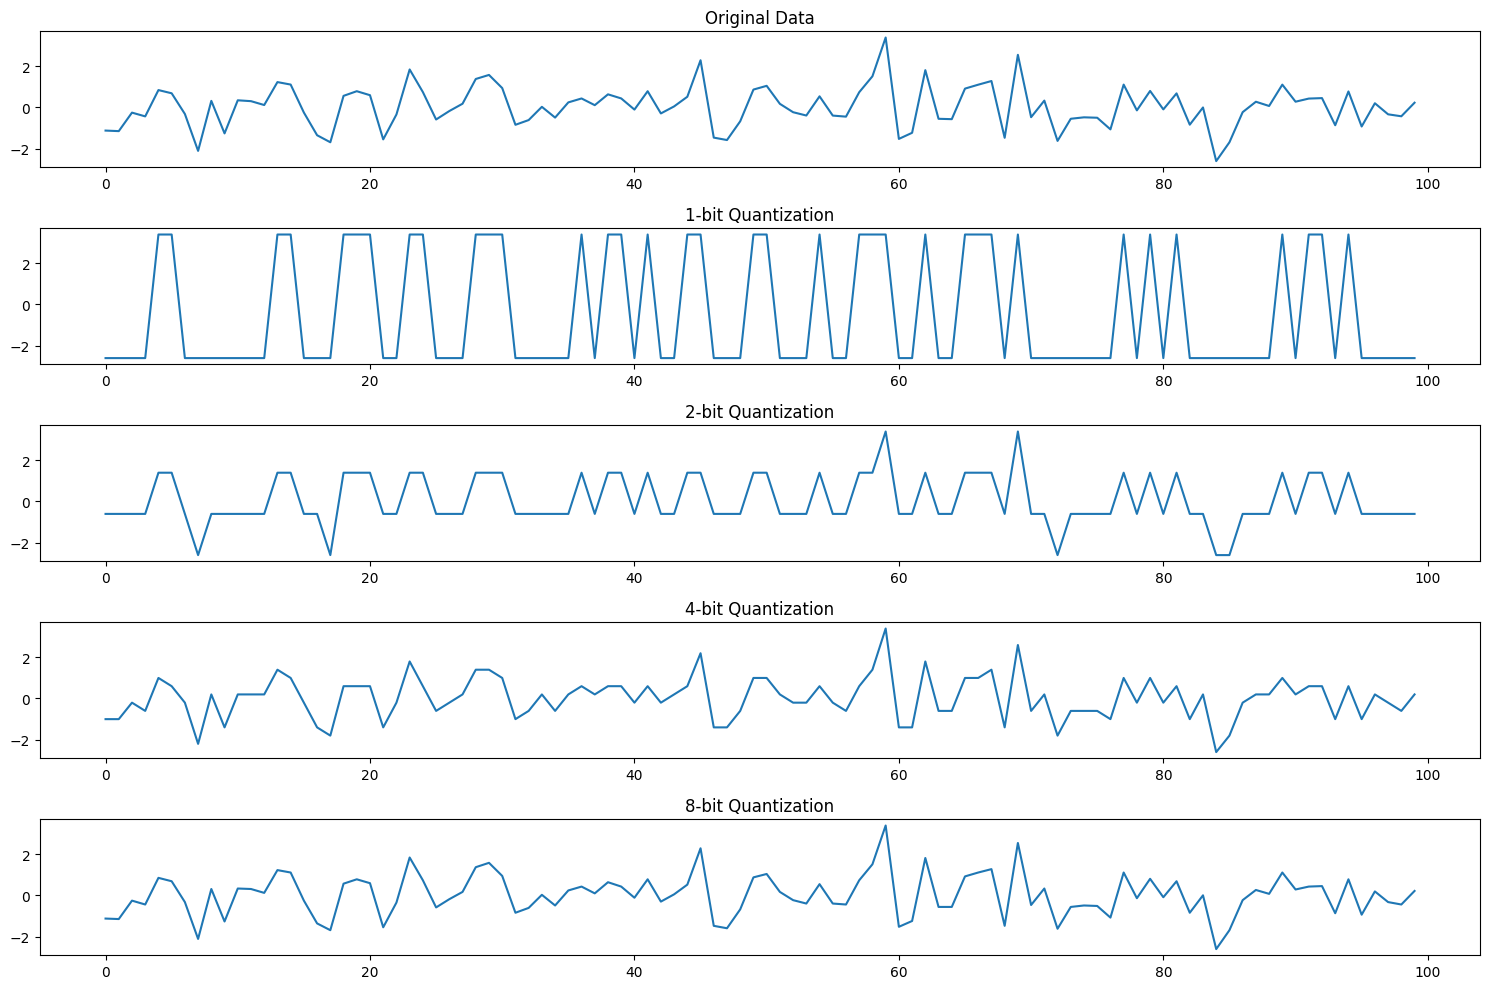

In [2]:
import torch
import matplotlib.pyplot as plt

def test_quantization(seed=0):
    # Create a sample tensor
    torch.manual_seed(seed)  # for reproducibility
    x = torch.randn(1, 100)  # 1x100 tensor of random values

    # Test different bit sizes
    bit_sizes = [1, 2, 4, 8]
    
    plt.figure(figsize=(15, 10))
    plt.subplot(len(bit_sizes) + 1, 1, 1)
    plt.plot(x.squeeze().numpy())
    plt.title("Original Data")
    
    for i, bits in enumerate(bit_sizes):
        quantized = quant(x, bits)
        
        plt.subplot(len(bit_sizes) + 1, 1, i + 2)
        plt.plot(quantized.squeeze().numpy())
        plt.title(f"{bits}-bit Quantization")
        
        print(f"\n{bits}-bit Quantization:")
        print("Min value:", quantized.min().item())
        print("Max value:", quantized.max().item())
        print("Unique values:", torch.unique(quantized).numel())
        
    plt.tight_layout()
    plt.show()

test_quantization()

## Memory efficient nbitlinear static

Original model:
Hidden layer weights:
  Min value: -0.0999840646982193
  Max value: 0.09996763616800308
  Unique values: 4998

Replacing linear layers with weight bits:16

16-bit Quantization:
Output min value: -0.4655658006668091
Output max value: 0.6563711166381836
Output unique values: 10
Hidden layer weights:
  Min value: -0.09998348355293274
  Max value: 0.09996823221445084
  Unique values: 4819

Replacing linear layers with weight bits:8

8-bit Quantization:
Output min value: -0.46523237228393555
Output max value: 0.6568669080734253
Output unique values: 10
Hidden layer weights:
  Min value: -0.10036791861057281
  Max value: 0.09958379715681076
  Unique values: 256

Replacing linear layers with weight bits:4

4-bit Quantization:
Output min value: -0.460723876953125
Output max value: 0.6282358169555664
Output unique values: 10
Hidden layer weights:
  Min value: -0.10664091259241104
  Max value: 0.09331079572439194
  Unique values: 16

Replacing linear layers with weight bits:2

2-

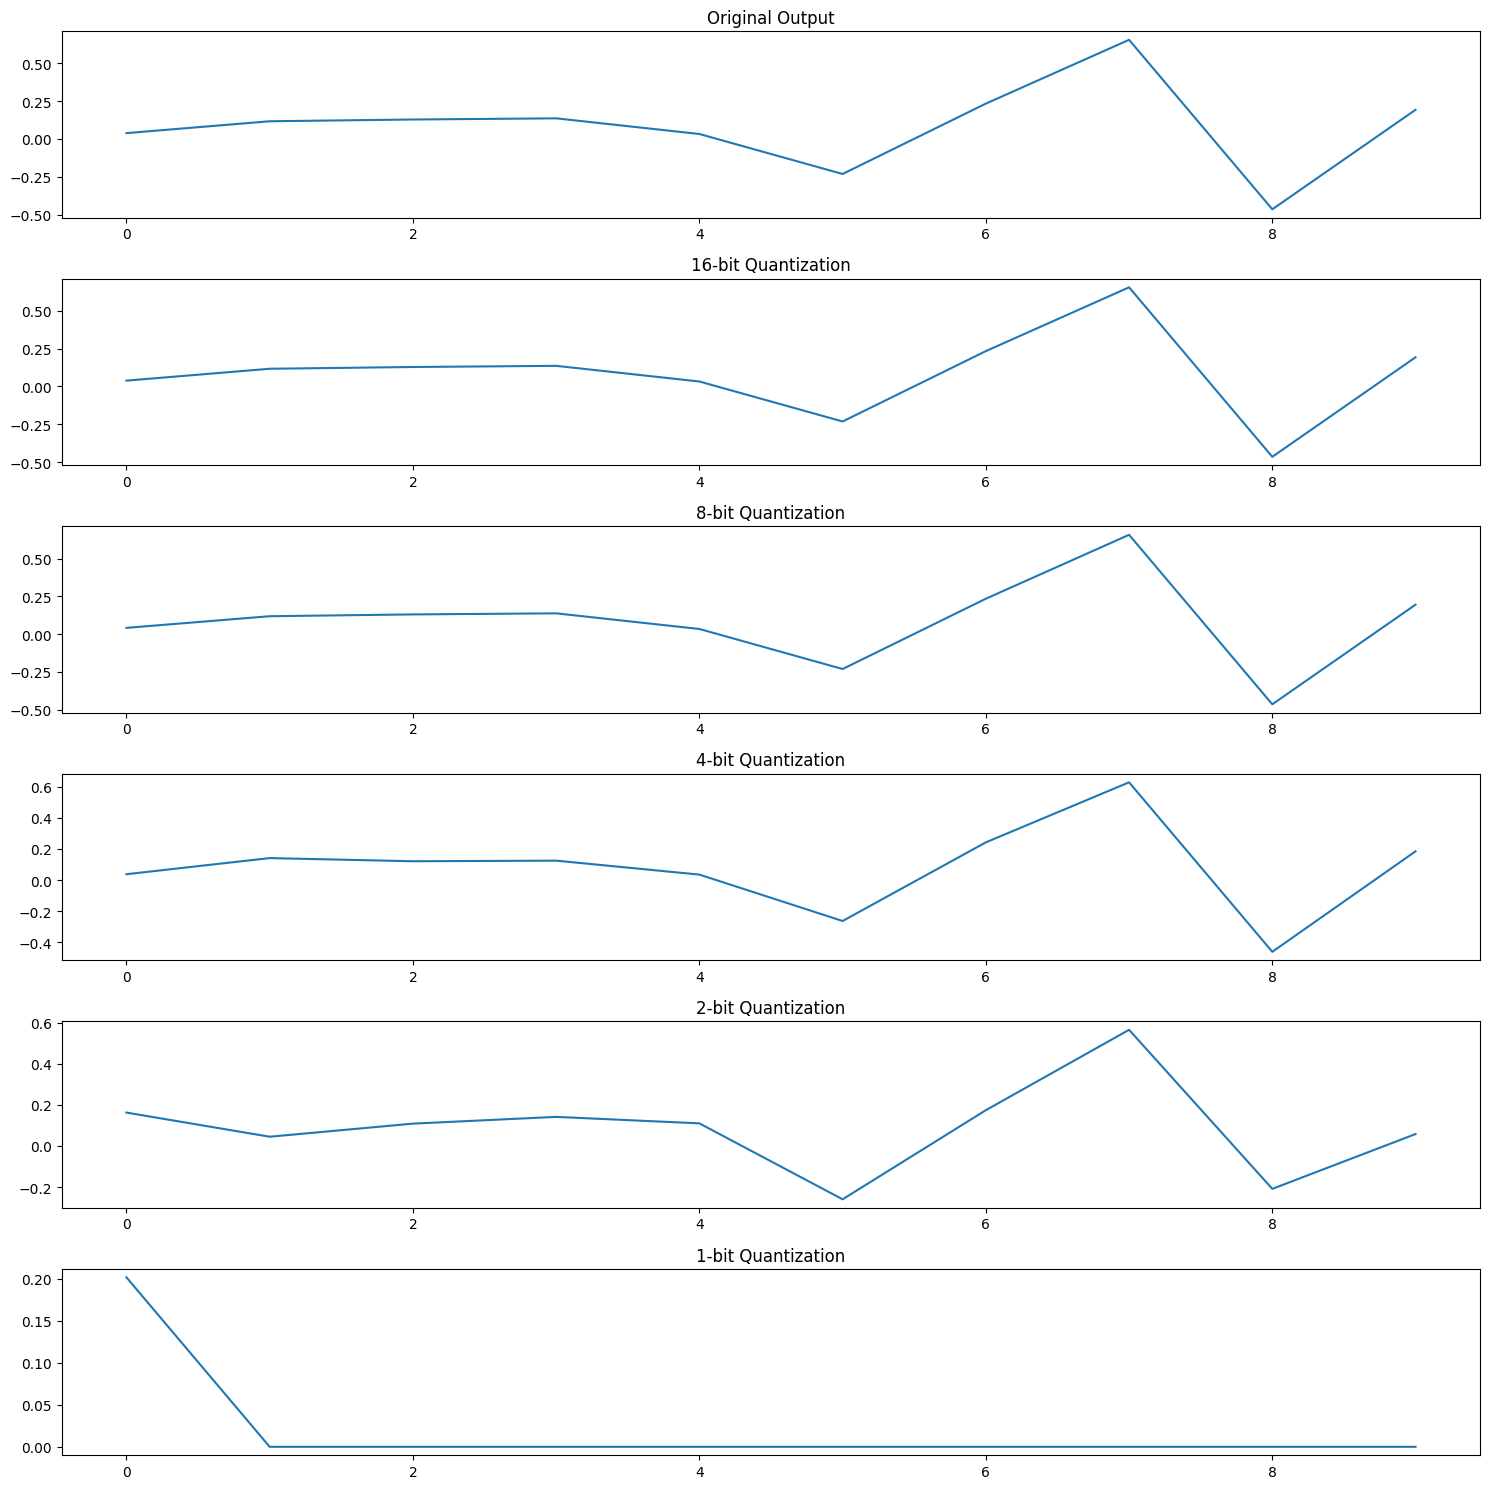

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import copy

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x

def quant(x: torch.Tensor, num_bits):
    min_val = x.min()
    max_val = x.max()
    
    if min_val == max_val:
        return x
    
    scale = (2**num_bits - 1) / (max_val - min_val)
    zero_point = (-min_val * scale).round()
    
    x_int = (x * scale + zero_point).round().clamp(0, 2**num_bits - 1)
    x_quant = (x_int - zero_point) / scale
    
    return x_quant

def replace_linear_with_quantized(model: nn.Module, weight_bits: int = 2, dynamic=False) -> nn.Module:
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            module.weight.data = quant(module.weight.data, weight_bits)
            if module.bias is not None:
                module.bias.data = quant(module.bias.data, weight_bits)
        elif isinstance(module, nn.Module):
            replace_linear_with_quantized(module, weight_bits, dynamic)
    return model

def test_nn_quantization(seed=0, input_size=100, hidden_size=50, output_size=10):
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create a simple neural network
    original_model = SimpleNN(input_size, hidden_size, output_size).to(device)
    
    # Create a sample input
    x = torch.randn(1, input_size).to(device)
    
    # Get original output
    with torch.no_grad():
        original_output = original_model(x)
    
    print("Original model:")
    print("Hidden layer weights:")
    print("  Min value:", original_model.hidden.weight.data.min().item())
    print("  Max value:", original_model.hidden.weight.data.max().item())
    print("  Unique values:", torch.unique(original_model.hidden.weight.data).numel())
    
    # Move original model to CPU and clear GPU memory
    original_model = original_model.cpu()
    torch.cuda.empty_cache()
    
    # Test different bit sizes
    bit_sizes = [16, 8, 4, 2, 1]
    
    plt.figure(figsize=(15, 15))
    plt.subplot(len(bit_sizes) + 1, 1, 1)
    plt.plot(original_output.cpu().squeeze().numpy())
    plt.title("Original Output")
    
    for i, bits in enumerate(bit_sizes):
        print(f"\nReplacing linear layers with weight bits:{bits}")

        # Move original model to CPU and clear GPU memory
        original_model = original_model.cpu()
        torch.cuda.empty_cache()
        # Create a deep copy of the original model and move it to GPU
        quantized_model = copy.deepcopy(original_model).to(device)
        # Quantize the model
        quantized_model = replace_linear_with_quantized(quantized_model, weight_bits=bits, dynamic=False)
        
        # Get quantized output
        with torch.no_grad():
            quantized_output = quantized_model(x)
        
        plt.subplot(len(bit_sizes) + 1, 1, i + 2)
        plt.plot(quantized_output.cpu().squeeze().numpy())
        plt.title(f"{bits}-bit Quantization")
        
        print(f"\n{bits}-bit Quantization:")
        print("Output min value:", quantized_output.min().item())
        print("Output max value:", quantized_output.max().item())
        print("Output unique values:", torch.unique(quantized_output).numel())
        
        # Print some stats about the hidden layer weights
        hidden_weights = quantized_model.hidden.weight.data
        print("Hidden layer weights:")
        print("  Min value:", hidden_weights.min().item())
        print("  Max value:", hidden_weights.max().item())
        print("  Unique values:", torch.unique(hidden_weights).numel())
        
        # Clear the quantized model from GPU memory
        del quantized_model
        torch.cuda.empty_cache()
    
    plt.tight_layout()
    plt.show()

# Run the test
test_nn_quantization()

In [8]:
import torch
from torch import nn
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from datasets import COCODataset
from tqdm import tqdm
import json
import time

def compare_quantization_methods(model, processor, coco_dataset, device, weight_bits=2, num_samples=50):
    results = {
        'original': [],
        'dynamic': [],
        'static': []
    }
    times = {
        'original': 0,
        'dynamic': 0,
        'static': 0
    }

    # Original model evaluation
    print("Evaluating original model...")
    start_time = time.time()
    results['original'] = eval_model(model, coco_dataset, processor, device, num_samples)
    times['original'] = time.time() - start_time

    # # Save original state
    # original_state = {name: param.clone() for name, param in model.state_dict().items()}

    # # Dynamic quantization
    # print("Evaluating dynamically quantized model...")
    # model = replace_linear_with_quantized(model, weight_bits=weight_bits, dynamic=True)
    # model.to(device)  # Ensure the entire model is on the correct device
    # start_time = time.time()
    # results['dynamic'] = eval_model(model, coco_dataset, processor, device, num_samples)
    # times['dynamic'] = time.time() - start_time

    # # Restore original state
    # model.load_state_dict(original_state)

    # Static quantization
    print("Evaluating statically quantized model...")
    # Move original model to CPU and clear GPU memory
    model = model.cpu()
    torch.cuda.empty_cache()
    # Create a deep copy of the original model and move it to GPU
    print("Attempting copy")
    model = copy.deepcopy(model).to(device)
    print("Copy succeeded")
    model = replace_linear_with_quantized(model, weight_bits=4, dynamic=False)
    start_time = time.time()
    results['static'] = eval_model(model, coco_dataset, processor, device, num_samples)
    times['static'] = time.time() - start_time

    return results, times
    

def eval_model(model, dataset, processor, device, num_samples):
    results = []
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        for i in tqdm(range(min(num_samples, len(dataset)))):
            image, _ = dataset[i]
            
            inputs = processor(images=image, return_tensors="pt").to(device)
            # Ensure all input tensors are on the correct device
            inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
            out = model.generate(**inputs)
            
            caption = processor.decode(out[0], skip_special_tokens=True).strip()
            
            image_id = dataset.ids[i]
            results.append({"image_id": image_id, "caption": caption})
    return results

def save_results(results, times, filename):
    output = {
        'results': results,
        'times': times
    }
    with open(filename, 'w') as f:
        json.dump(output, f, indent=2)

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load BLIP-2 model and processor
    processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
    model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b")
    model = model.to(device)
    
    # Load COCO dataset
    coco_dataset = COCODataset(ann_file='./data/coco/annotations/captions_val2017.json',
                               img_dir='./data/coco/val2017')
    
    # Compare quantization methods
    results, times = compare_quantization_methods(model, processor, coco_dataset, device, weight_bits=2, num_samples=50)
    
    # Save results
    save_results(results, times, "./results/quantization_comparison.json")
    
    print("Evaluation complete. Results saved to ./results/quantization_comparison.json")
    print("Execution times:")
    for method, time in times.items():
        print(f"{method}: {time:.2f} seconds")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Evaluating original model...


100%|███████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


Evaluating statically quantized model...
Attempting copy
Copy succeeded


100%|███████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.85it/s]

Evaluation complete. Results saved to ./results/quantization_comparison.json
Execution times:
original: 15.75 seconds
dynamic: 0.00 seconds
static: 27.02 seconds


In [5]:
times

{'original': 16.066415071487427, 'dynamic': 0, 'static': 13.239070653915405}

In [6]:
import torch
from torch import nn
from tqdm import tqdm
import time
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from datasets import COCODataset
import json

def test_static_quantization(model, processor, coco_dataset, device, weight_bits=2, num_samples=5):
    print("Testing static quantization...")
    
    # Apply static quantization
    model = replace_linear_with_quantized(model, weight_bits=weight_bits, dynamic=False)
    model.to(device)

    results = []
    start_time = time.time()

    model.eval()
    with torch.no_grad():
        for i in tqdm(range(min(num_samples, len(coco_dataset)))):
            image, _ = coco_dataset[i]
            
            inputs = processor(images=image, return_tensors="pt").to(device)
            # Ensure all input tensors are on the correct device
            inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
            
            try:
                out = model.generate(**inputs)
                caption = processor.decode(out[0], skip_special_tokens=True).strip()
                results.append({"image_id": coco_dataset.ids[i], "caption": caption})
            except RuntimeError as e:
                print(f"Error processing image {i}: {str(e)}")
                # Print device information for debugging
                print(f"Input device: {inputs['pixel_values'].device}")
                for name, param in model.named_parameters():
                    if param.device != device:
                        print(f"Parameter {name} is on {param.device}, expected {device}")
                break

    end_time = time.time()
    
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    print(f"Number of successful inferences: {len(results)}")
    
    return results

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BLIP-2 model and processor
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b")
model = model.to(device)

# Load COCO dataset
coco_dataset = COCODataset(ann_file='./data/coco/annotations/captions_val2017.json',
                           img_dir='./data/coco/val2017')

# Test static quantization
results = test_static_quantization(model, processor, coco_dataset, device, weight_bits=2, num_samples=5)

# Print results
for result in results:
    print(f"Image ID: {result['image_id']}")
    print(f"Caption: {result['caption']}")
    print()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Testing static quantization...


100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]

Time taken: 2.68 seconds
Number of successful inferences: 5
Image ID: 397133
Caption: unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev

Image ID: 37777
Caption: unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev

Image ID: 252219
Caption: unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev

Image ID: 87038
Caption: unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev

Image ID: 174482
Caption: unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbeliev unbelie

Original model:
Hidden layer weights:
  Min value: -0.0999840646982193
  Max value: 0.09996763616800308
  Unique values: 4998

Replacing linear layers with weight bits:16

16-bit Quantization:
Output min value: -0.4655658006668091
Output max value: 0.6563711166381836
Output unique values: 10
Hidden layer weights:
  Min value: -0.09998348355293274
  Max value: 0.09996823221445084
  Unique values: 4819

Replacing linear layers with weight bits:8

8-bit Quantization:
Output min value: -0.46523237228393555
Output max value: 0.6568669080734253
Output unique values: 10
Hidden layer weights:
  Min value: -0.10036791861057281
  Max value: 0.09958379715681076
  Unique values: 256

Replacing linear layers with weight bits:4

4-bit Quantization:
Output min value: -0.460723876953125
Output max value: 0.6282358169555664
Output unique values: 10
Hidden layer weights:
  Min value: -0.10664091259241104
  Max value: 0.09331079572439194
  Unique values: 16

Replacing linear layers with weight bits:2

2-

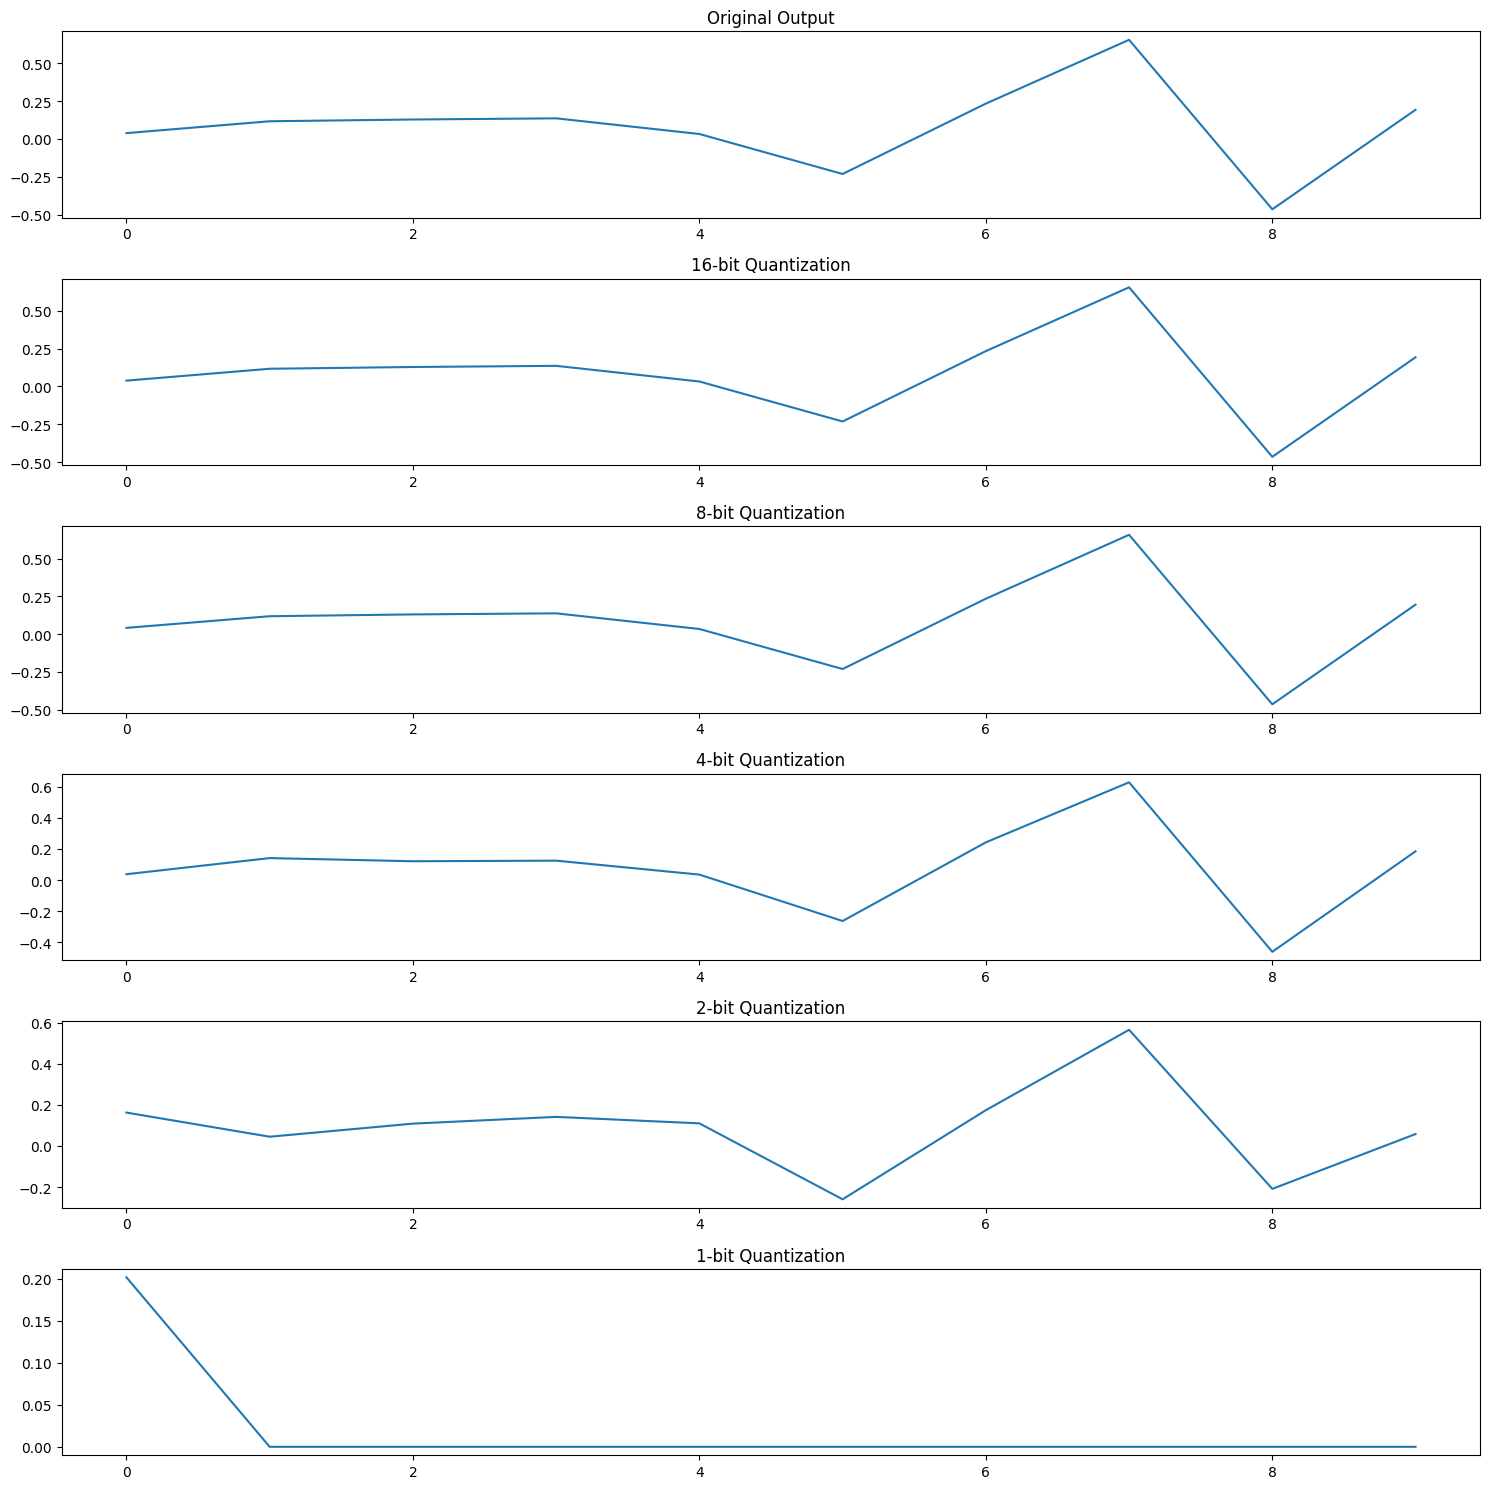

In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import copy

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x

def quant(x: torch.Tensor, num_bits):
    min_val = x.min()
    max_val = x.max()
    
    if min_val == max_val:
        return x
    
    scale = (2**num_bits - 1) / (max_val - min_val)
    zero_point = (-min_val * scale).round()
    
    x_int = (x * scale + zero_point).round().clamp(0, 2**num_bits - 1)
    x_quant = (x_int - zero_point) / scale
    
    return x_quant

def replace_linear_with_quantized(model: nn.Module, weight_bits: int = 2, dynamic=False) -> nn.Module:
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            module.weight.data = quant(module.weight.data, weight_bits)
            if module.bias is not None:
                module.bias.data = quant(module.bias.data, weight_bits)
        elif isinstance(module, nn.Module):
            replace_linear_with_quantized(module, weight_bits, dynamic)
    return model

def test_nn_quantization(seed=0, input_size=100, hidden_size=50, output_size=10):
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create a simple neural network
    original_model = SimpleNN(input_size, hidden_size, output_size).to(device)
    
    # Create a sample input
    x = torch.randn(1, input_size).to(device)
    
    # Get original output
    with torch.no_grad():
        original_output = original_model(x)
    
    print("Original model:")
    print("Hidden layer weights:")
    print("  Min value:", original_model.hidden.weight.data.min().item())
    print("  Max value:", original_model.hidden.weight.data.max().item())
    print("  Unique values:", torch.unique(original_model.hidden.weight.data).numel())
    
    # Move original model to CPU and clear GPU memory
    original_model = original_model.cpu()
    torch.cuda.empty_cache()
    
    # Test different bit sizes
    bit_sizes = [16, 8, 4, 2, 1]
    
    plt.figure(figsize=(15, 15))
    plt.subplot(len(bit_sizes) + 1, 1, 1)
    plt.plot(original_output.cpu().squeeze().numpy())
    plt.title("Original Output")
    
    for i, bits in enumerate(bit_sizes):
        print(f"\nReplacing linear layers with weight bits:{bits}")
        
        # Create a deep copy of the original model and move it to GPU
        quantized_model = copy.deepcopy(original_model).to(device)
        
        # Quantize the model
        quantized_model = replace_linear_with_quantized(quantized_model, weight_bits=bits, dynamic=False)
        
        # Get quantized output
        with torch.no_grad():
            quantized_output = quantized_model(x)
        
        plt.subplot(len(bit_sizes) + 1, 1, i + 2)
        plt.plot(quantized_output.cpu().squeeze().numpy())
        plt.title(f"{bits}-bit Quantization")
        
        print(f"\n{bits}-bit Quantization:")
        print("Output min value:", quantized_output.min().item())
        print("Output max value:", quantized_output.max().item())
        print("Output unique values:", torch.unique(quantized_output).numel())
        
        # Print some stats about the hidden layer weights
        hidden_weights = quantized_model.hidden.weight.data
        print("Hidden layer weights:")
        print("  Min value:", hidden_weights.min().item())
        print("  Max value:", hidden_weights.max().item())
        print("  Unique values:", torch.unique(hidden_weights).numel())
        
        # Clear the quantized model from GPU memory
        del quantized_model
        torch.cuda.empty_cache()
    
    plt.tight_layout()
    plt.show()

# Run the test
test_nn_quantization()

Original model:
Hidden layer weights:
  Min value: -0.0999840646982193
  Max value: 0.09996763616800308
  Unique values: 4998


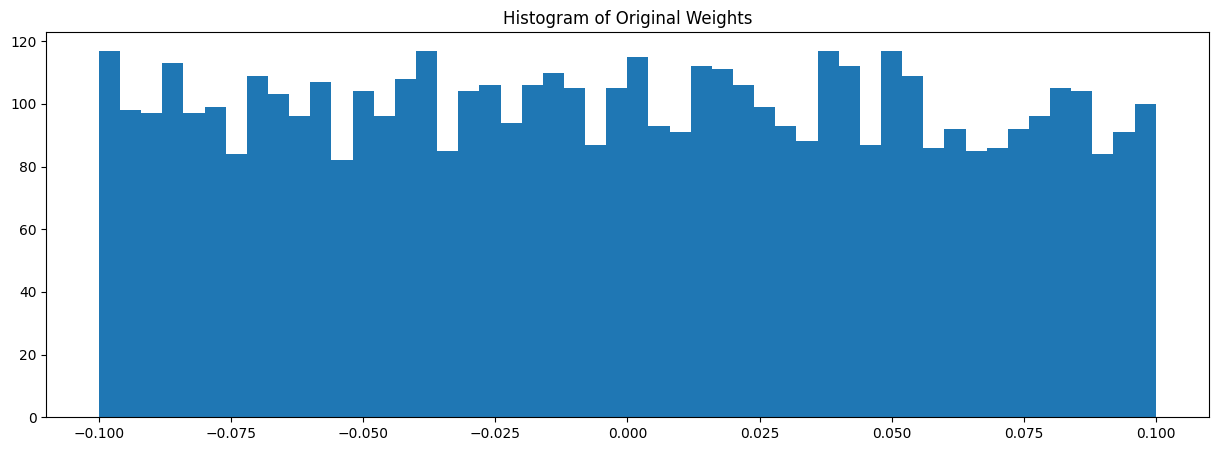


Replacing linear layers with weight bits:1

1-bit Quantization:
Output min value: 0.0
Output max value: 0.12499482929706573
Output unique values: 2
Hidden layer weights:
  Min value: -0.0999840646982193
  Max value: 0.0
  Unique values: 2


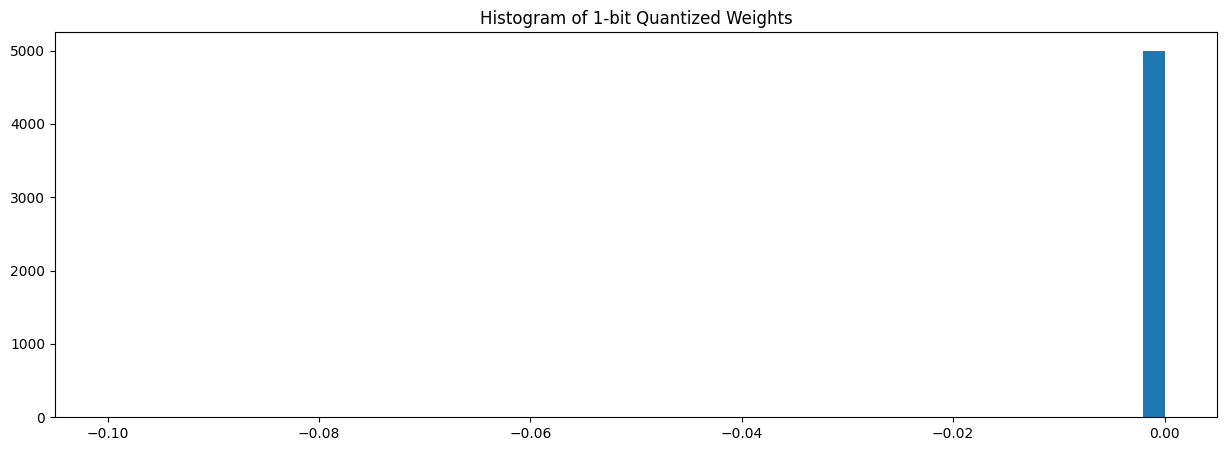


Replacing linear layers with weight bits:2

2-bit Quantization:
Output min value: 0.0
Output max value: 0.12499482929706573
Output unique values: 2
Hidden layer weights:
  Min value: -0.0999840646982193
  Max value: 0.0
  Unique values: 2


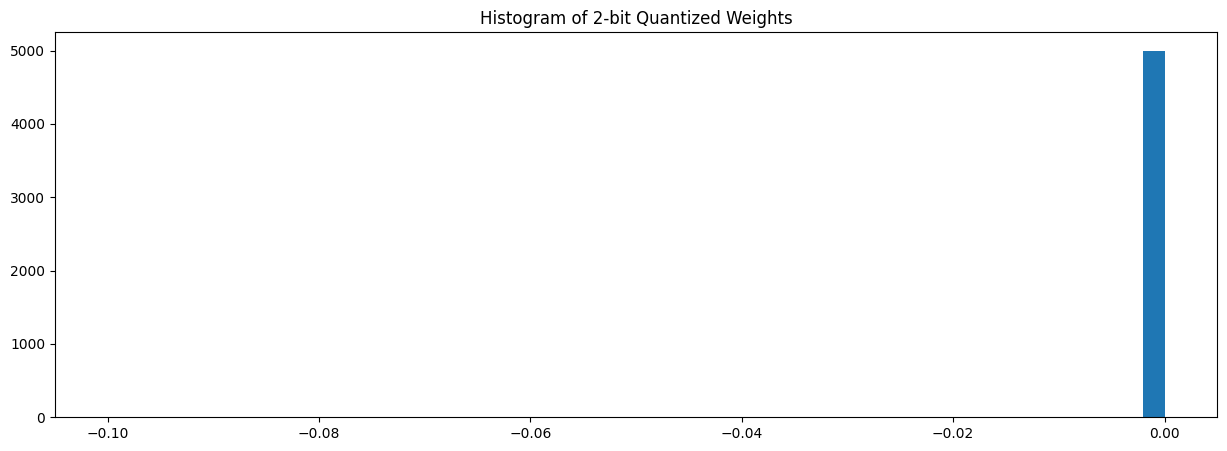


Replacing linear layers with weight bits:4

4-bit Quantization:
Output min value: 0.0
Output max value: 0.12499482929706573
Output unique values: 2
Hidden layer weights:
  Min value: -0.0999840646982193
  Max value: 0.0
  Unique values: 2


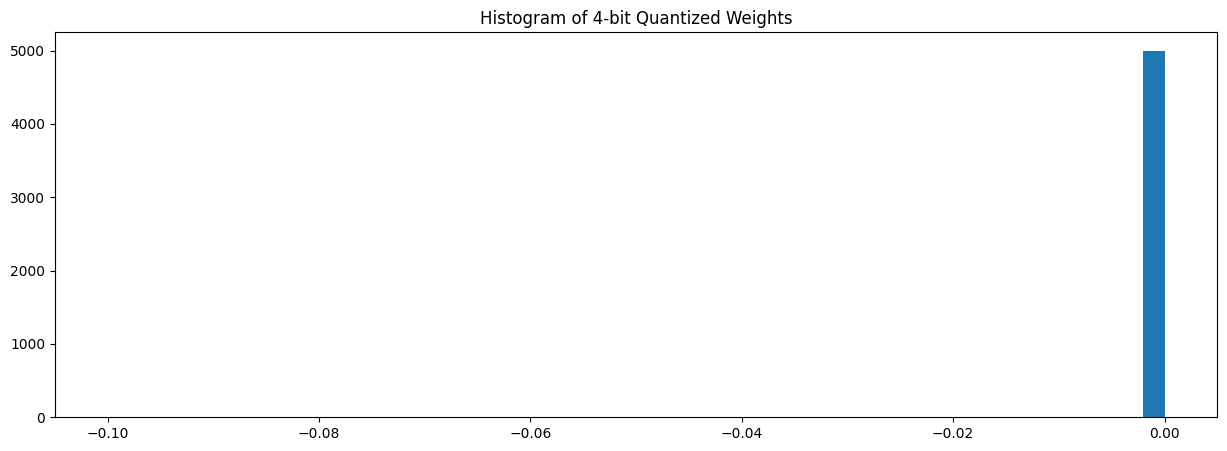


Replacing linear layers with weight bits:8

8-bit Quantization:
Output min value: 0.0
Output max value: 0.12499482929706573
Output unique values: 2
Hidden layer weights:
  Min value: -0.0999840646982193
  Max value: 0.0
  Unique values: 2


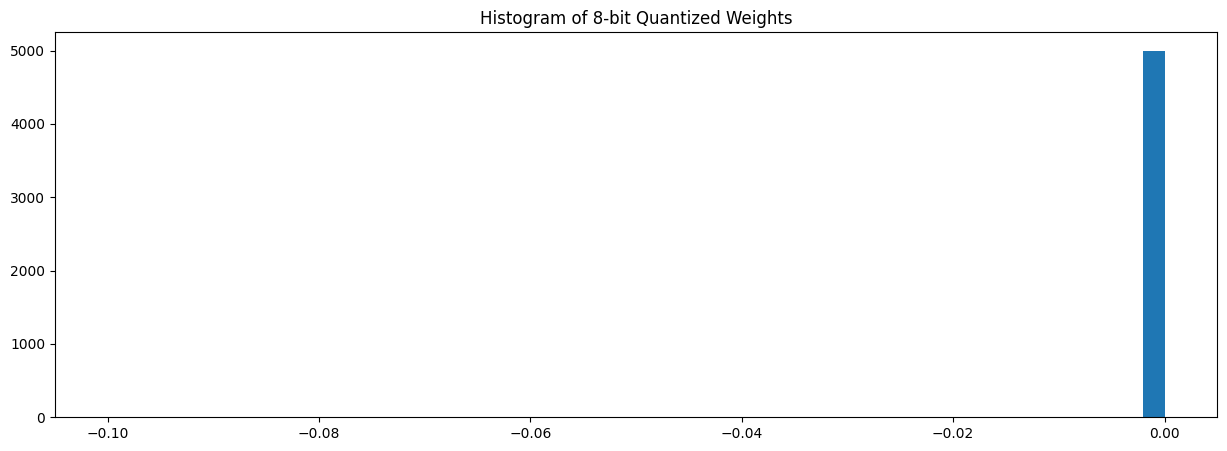

In [6]:
def quant(x: Tensor, num_bits):
    min_val = x.min()
    max_val = x.max()
    
    if min_val == max_val:
        return x
    
    scale = (2**num_bits - 1) / (max_val - min_val)
    zero_point = (-min_val * scale).round()
    
    x_int = (x * scale + zero_point).round()
    x_quant = (x_int - zero_point) / scale
    
    return x_quant.clamp(min_val, max_val)

class NBitLinearStatic(nn.Linear):
    def __init__(self,
                 in_features,
                 out_features,
                 bias=True,
                 weight_bits=8):
        super().__init__(in_features, out_features, bias)
        self.weight_bits = weight_bits
        self.quantize_weights()
        
    def quantize_weights(self):
        self.weight.data = quant(self.weight.data, self.weight_bits)
        if self.bias is not None:
            self.bias.data = quant(self.bias.data, self.weight_bits)
        
    def forward(self, x: Tensor) -> Tensor:
        return F.linear(x, self.weight, self.bias)
    
    def extra_repr(self) -> str:
        return super().extra_repr() + f' | w={self.weight_bits}'

